# Build A Custom Extractor For Documents

> This workflow is part of a series of workflows for the solution prototype: [Document Processing With Generative AI: Parse, Extract, Validate Authenticity, and More](./readme.md)

When a document, such as an invoice, arrives, it is often in the form of an image. To make this document useful for processing, essential information must be extracted. In some cases, this might be as simple as identifying the vendor's name to route the document to the appropriate review queue. In other cases, more detailed information is needed, including repeating data like invoice line items and their associated elements, such as SKU, description, price, and quantity. This is where the [Document AI Custom Extractor](https://cloud.google.com/document-ai/docs/custom-extractor-overview) is valuable. In this project, we will leverage the [Custom extractor with generative AI](https://cloud.google.com/document-ai/docs/ce-with-genai) version to ensure a simple and effective process across the variety of invoice formats, which can vary significantly from vendor to vendor.

> Document AI offers a range of parsers for various tasks, including [OCR](https://cloud.google.com/document-ai/docs/enterprise-document-ocr), general form extraction with the [Form Parser](https://cloud.google.com/document-ai/docs/form-parser), and document preparation for generative AI retrieval pipelines using the [Layout Parser](https://cloud.google.com/document-ai/docs/layout-parse-chunk).

Setting up the `Custom extractor with generative AI` is an interactive process with many automated features available directly in the Google Cloud Console. The resulting parser can be accessed via REST, gRPC, and numerous client libraries - [reference](https://cloud.google.com/document-ai/docs/reference). The console-based workflow and client usage with Python are detailed step-by-step in the included workflow [1-extraction.ipynb](./1-extraction.ipynb).

> This workflow will uses the documents setup in the prior workflow: [0-generate-documents.ipynb](./0-generate-documents.ipynb)

**Workflow**
- Use: Document AI Custom Extractor With Generative AI
  - Create a zero-shot parser using just an included foundational model for extraction
    - Create, Evaluate test documents, procesess online documents, review extraction
  - Create a multi-shot parser version from the foundation model for extraction
  - Fine-tune a parser for increased accuracy

**References**
- [Document AI documentation](https://cloud.google.com/document-ai/docs/overview)
- [Document AI API, Clients](https://cloud.google.com/document-ai/docs/reference)
- More examples in this repository:
  - Many examples and tip for [Working With Document AI](../../../Working%With/Document%20AI/readme.md)
  - Document AI Layout Parser for [Chunking and Parsing](../../../Applied%20GenAI/Chunking/readme.md) documents of all sizes and volumes

## Setup

Note that this notebook expects to use a local virtual environment with the `./requirements.txt` installed.  

A potential workaround if using this notebook standalone is running:

>```python
>pip install -r requirements.txt
>```

And then restart the kernel.

In [31]:
# package imports for this work
import os, subprocess, io, base64

import IPython.display
import fitz

from google.cloud import documentai
from google.cloud import storage

In [5]:
# what project are we working in?
PROJECT_ID = subprocess.run(['gcloud', 'config', 'get-value', 'project'], capture_output=True, text=True, check=True).stdout.strip()
PROJECT_ID

'statmike-mlops-349915'

In [7]:
LOCATION = 'us-central1'

SERIES = 'applied-ml-solution-prototypes'
EXPERIMENT = 'document-processing'
GCS_BUCKET = PROJECT_ID # bucket has same name as project here

In [9]:
# setup google cloud storage client
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# setup document AI Client
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION[0:2]}-documentai.googleapis.com")
)

---
## Custom Extractor: Zero-Shot

Start in the console by following along with https://cloud.google.com/document-ai/docs/ce-with-genai

1. - Create A Processor
    - `Console > Document AI > Overview > Create Custom Processor`
      - <img src='./resources/images/extract-zero-shot/screen_1.png'></img>
    - This takes us to `Document AI > Custom Processors`
      - Under 'Custom Extractor' Click 'Create Processor'
      - <img src='./resources/images/extract-zero-shot/screen_2.png'></img>
    - A flyover to the right has prompts to name the processor, `document-processing` in this case, and select the region (`us` in this case). Then click `Create`.
      - <img src='./resources/images/extract-zero-shot/screen_3.png'></img>
    - This takes us to the new processors overview page:
      - <img src='./resources/images/extract-zero-shot/screen_4.png'></img>
2. -  Define A Schema
    - Under `Get Started` use `Create New Field` to define fields for extraction
    - Add Fields to define the desired extractions:
      - Names, types, and descriptions are important as they are link context for prompts to help identify the information during processing of the document.
      - <img src='./resources/images/extract-zero-shot/screen_5.png'></img>
3. - Zero-Shot Training (Really just directly using the selected foundation model)
    - For zero-shot only a test set of documents is needed, no training documents
    - Under `Build` Select `Import documents` with auto-labeling and assign them to the test split
      - here, 5 documents were loaded, the first invoice, `0.pdf`, from each of 5 different vendors
      - <img src='./resources/images/extract-zero-shot/screen_6.png'></img>
    - Once the documents are loaded select the `Start Labeling` button under `Build`
      - <img src='./resources/images/extract-zero-shot/screen_7.png'></img>
    - The first document will dispaly with the auto-labeling result annotated. Review these and confirm or edit them using the tools in the console:
      - <img src='./resources/images/extract-zero-shot/screen_8.png'></img>
    - Once confirmed the color changes from purple to blue:
      - <img src='./resources/images/extract-zero-shot/screen_9.png'></img>
    - Select `Mark As Labeled` once complete and it will take you to the next document:
      - <img src='./resources/images/extract-zero-shot/screen_10.png'></img>
    - Note that `Mark As Labeled` also accepts all the proposed auto-labeling and proceeds to the next document
    - Once labeling is complete you are returned to the `Build` page and it is updated to show 5 labeled documents.
      - <img src='./resources/images/extract-zero-shot/screen_11.png'></img>
    - Now, for our zero-shot version, we skip directly to the `Evaluate & test` section:
      - <img src='./resources/images/extract-zero-shot/screen_12.png'></img>
    - Click the `Run New Evaluation` button, then on the pop-up select the `Run Evaluation` button:
      - <img src='./resources/images/extract-zero-shot/screen_13.png'></img>
    - Evaluation will commense and the console will indicate the processing is running:
      - <img src='./resources/images/extract-zero-shot/screen_14.png'></img>
    - Once complete, the results of the evaluation will be summarized:
      - <img src='./resources/images/extract-zero-shot/screen_15.png'></img>
    - Click the `View Full Evaluation` button to review the evaluation.  This will present the evaluaiton result overall (`All labels`) and for each individual label.  Clicking any of these reveals links to test documents for each type of evaluation result: true positive, true negative, false positive, and false negative.
      - <img src='./resources/images/extract-zero-shot/screen_16.png'></img>
    - Click the back arrow to leave evaluation.  Then select `Deploy & use`:
      - <img src='./resources/images/extract-zero-shot/screen_17.png'></img>
    - On the list of model version we see the pretrained version with F1 score from our evaluation.  Notice this version is already marked as the default based on our earlier selection when setting up the new parser and we have not actually trained a new version (more on this later).

### Test The Parser Using A Client, The Python Client

#### Get The Document

In [11]:
document = fitz.open('./resources/documents/apex_digital_solutions/invoices/1.pdf', filetype = 'pdf')

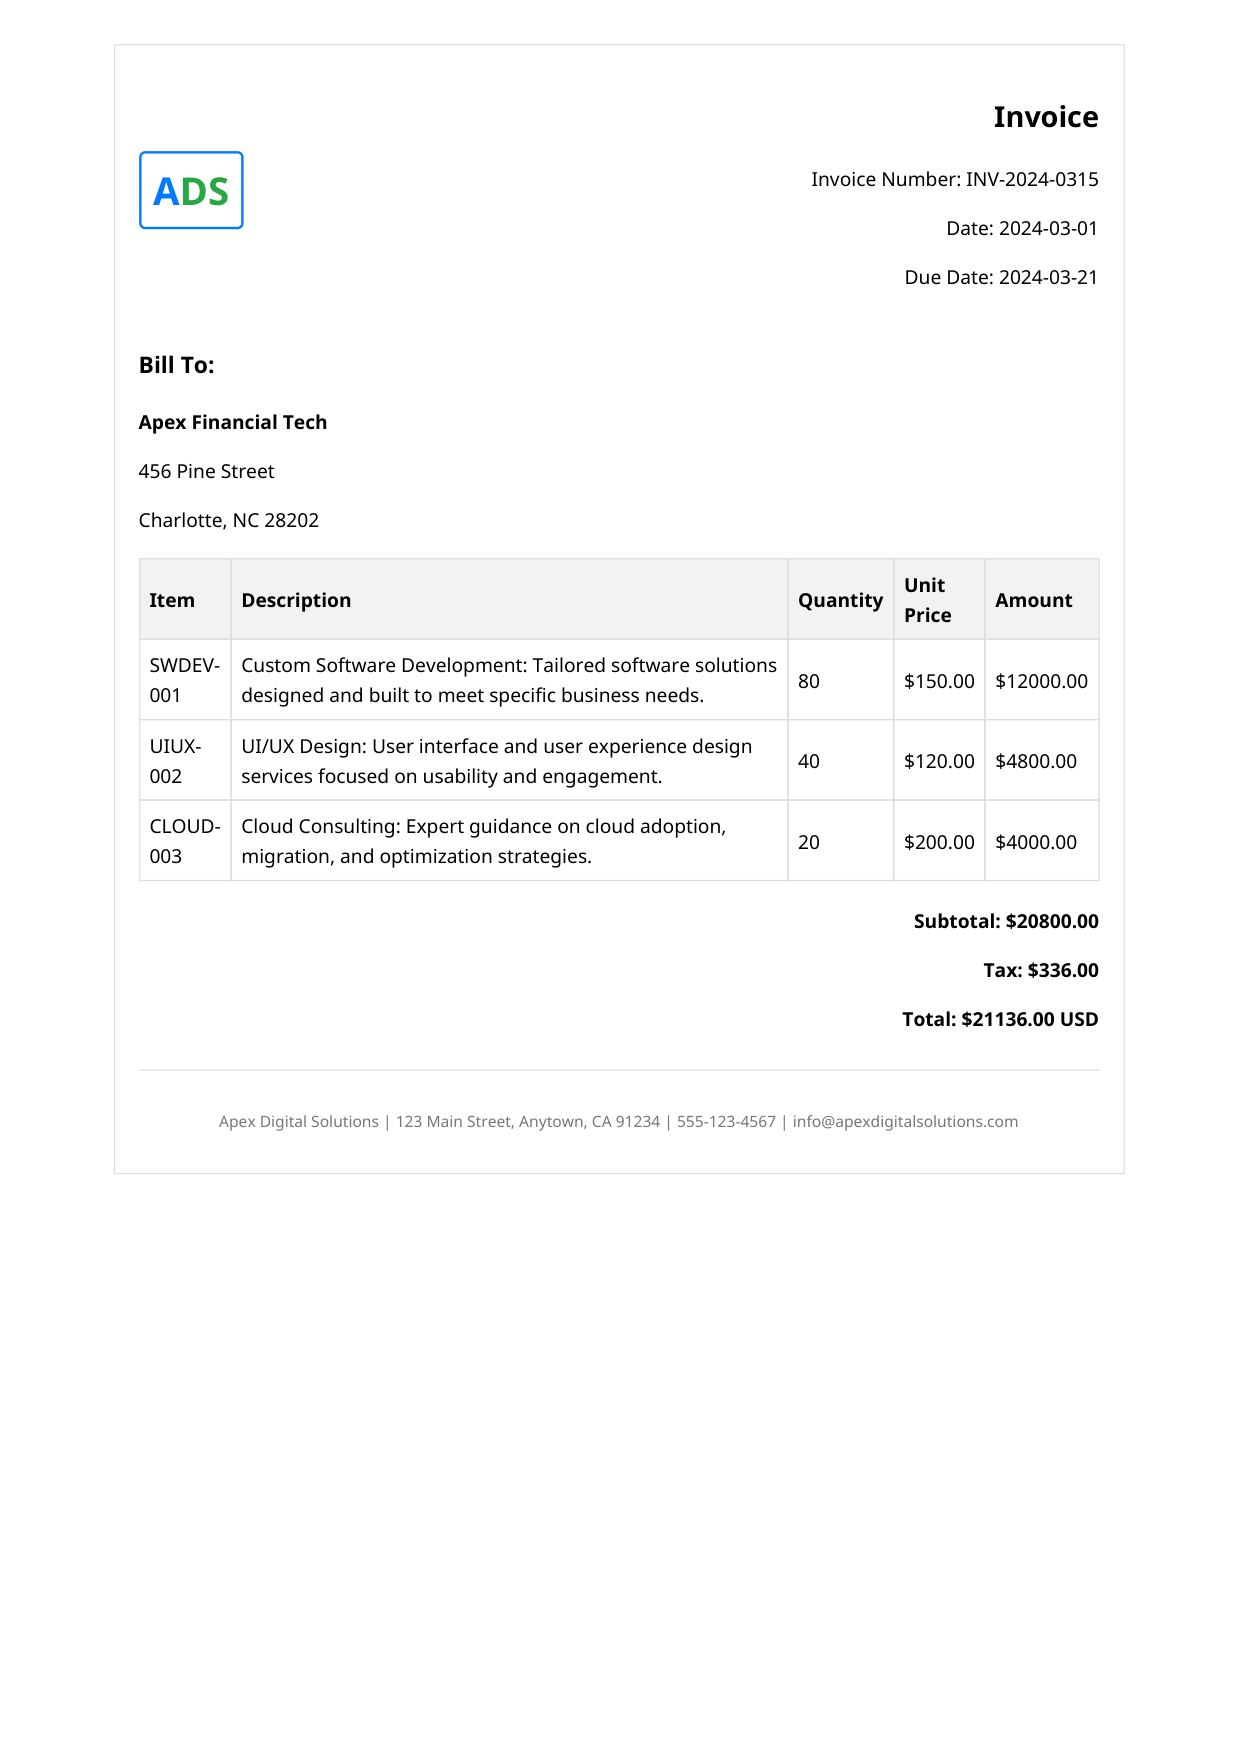

In [18]:
page = document.load_page(0)
pix = page.get_pixmap(dpi=150)
image = pix.tobytes('png')
IPython.display.display(IPython.display.Image(data = image, width = 700))

#### Get The DocAI Parser

In [29]:
for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION[0:2]}'):
    if p.display_name == 'document-processing':
        parser = p
        print(f"Found Processor: {parser.display_name}", f"\nDefault Version: {parser.default_processor_version}")

Found Processor: document-processing 
Default Version: projects/1026793852137/locations/us/processors/b7eed12907b35ad1/processorVersions/pretrained-foundation-model-v1.4-2025-02-05


#### Process The Document

There are multiple ways including:
- Batch
  - GCS document list
  - GCS document path
- Online
  - Inline with bytes (**used here**)
  - Raw document from local folder
  - GCS document

In [32]:
buffer = io.BytesIO()
document.save(buffer)
document_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')

In [33]:
online_inline_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = parser.name,
        inline_document = documentai.Document(
            content = document_bytes,
            mime_type = 'application/pdf'
        ),
    )
)

#### Review The Response

First the OCR text and then the **entity:value** pairs:

In [37]:
print(online_inline_response.document.text)

ADS
Bill To:
Apex Financial Tech
456 Pine Street
Charlotte, NC 28202
Invoice
Invoice Number: INV-2024-0315
Date: 2024-03-01
Due Date: 2024-03-21
Item
Description
Quantity
Unit
Price
Amount
SWDEV-
001
Custom Software Development: Tailored software solutions
designed and built to meet specific business needs.
80
$150.00
$12000.00
UIUX-
002
UI/UX Design: User interface and user experience design
services focused on usability and engagement.
40
$120.00
$4800.00
CLOUD-
003
Cloud Consulting: Expert guidance on cloud adoption,
migration, and optimization strategies.
20
$200.00
$4000.00
Subtotal:
$20800.00
Tax: $336.00
Total: $
21136.00 USD
Apex Digital Solutions | 123 Main Street, Anytown, CA 91234 | 555-123-4567 | info@apexdigitalsolutions.com



In [41]:
for e, entity in enumerate(online_inline_response.document.entities):
    a = entity.type_
    if entity.normalized_value:
        b = entity.normalized_value
    else:
        b = entity.mention_text
    
    print(f"--------- Entity {e} -------------:\n{a}\n{b}")
    
    if entity.properties:
        print(f"\n--------- Entity {e} Properties ---------:")
        for prop in entity.properties:
            if prop.normalized_value:
                c = prop.normalized_value
            else:
                c = prop.mention_text
            print(f'{prop.type_} = {c}')

--------- Entity 0 -------------:
invoice_total
$
21136.00 USD
--------- Entity 1 -------------:
invoice_id
INV-2024-0315
--------- Entity 2 -------------:
line_item


--------- Entity 2 Properties ---------:
item_description = Custom Software Development: Tailored software solutions
designed and built to meet specific business needs.
item_quantity = text: "80"

item_sku = SWDEV-
001
item_total = text: "12000 USD"
money_value {
  currency_code: "USD"
  units: 12000
}

--------- Entity 3 -------------:
line_item


--------- Entity 3 Properties ---------:
item_description = UI/UX Design: User interface and user experience design
services focused on usability and engagement.
item_quantity = text: "40"

item_sku = UIUX-
002
item_total = text: "4800 USD"
money_value {
  currency_code: "USD"
  units: 4800
}

--------- Entity 4 -------------:
line_item


--------- Entity 4 Properties ---------:
item_description = Cloud Consulting: Expert guidance on cloud adoption,
migration, and optimization

In [42]:
#online_inline_response.document.entities

---
## Custom Extractor: Multi-shot

In [ ]:
# parse response to show entity:value pairs
# create a new parser version for multi-shot
# process and show response output
# create a new parser version for fine-tuned
# process and show response output
# show switching version versus default version
# point to more exmaple in the repository
# point to future noteobok in this solution using BQML Process Documents and link to doc pages in docai and BQML for this